In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler

In [104]:
# Carregar o conjunto de dados
data = pd.read_csv('data.csv', index_col=0)

# Pré-processamento dos dados

A partir de uma análise rápida do dataset fornecido, foram removidos alguns atributos, sendo esses:

- **Breed**: O atributo referente ao nome das raças dos cachorros não foi julgado como necessário para o modelo, pois utiliza etiquetas únicas para cada raça, possivelmente detrimental ao modelo.

- **Demeanor_category**, **Energy_level_category**, **Grooming_frequency_category**, **Shedding_category** e **Trainability_category**: Há uma redundância com outros atributos (Seus correspondentes em numéricos '_values'), tornando-os desnecessários.

- **Description**: O objetivo final não está relacionado com Processamento de Linguagem Natural, tornando o atributo irrelevante e custoso, uma vez que haveria uma complexidade maior em sua utilzação.

- **Popularity**: 28.52% (79/277) da amostra precisaria ser removida ou preenchida de forma apropriada pois a coluna apresenta muitos valores 'NaN' (Not a number).

- **Temperament**: Assim como no atributo 'description', existe uma subjetividade no atributo, o que inviabiliza o uso dele na criação do modelo.

In [105]:
#Visualizar a quantidade de NaN (Not a Number) por coluna
nan_count = data.isna().sum()
print(nan_count)

description                     0
temperament                     1
popularity                     79
min_height                      0
max_height                      0
min_weight                      2
max_weight                      2
min_expectancy                  3
max_expectancy                  3
group                           0
grooming_frequency_value        7
grooming_frequency_category     7
shedding_value                 20
shedding_category              20
energy_level_value              6
energy_level_category           6
trainability_value             24
trainability_category          24
demeanor_value                 25
demeanor_category              25
dtype: int64


In [106]:
data.drop(columns=["description", "temperament", "grooming_frequency_category", "shedding_category", "energy_level_category", "trainability_category", "demeanor_category", "popularity"], axis=1, inplace=True)

data.describe()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
count,277.000000,277.000000,275.000000,275.000000,274.000000,274.000000,270.000000,257.000000,271.000000,253.000000,252.000000
mean,44.225801,52.720588,17.888858,27.291416,11.306569,13.832117,0.425926,0.529183,0.712915,0.624506,0.620635
std,14.238298,15.885454,12.290600,19.061416,1.817949,2.016668,0.198306,0.189068,0.168927,0.247271,0.201713
min,12.700000,17.780000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
25%,33.020000,38.100000,8.164663,12.927383,10.000000,13.000000,0.200000,0.400000,0.600000,0.400000,0.400000
50%,45.085000,53.340000,15.875733,24.947580,12.000000,14.000000,0.400000,0.600000,0.600000,0.600000,0.600000
75%,55.880000,66.040000,22.679619,34.019428,12.000000,15.000000,0.600000,0.600000,0.800000,0.800000,0.800000
max,76.200000,88.900000,68.038855,108.862169,16.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Limpeza e tratamento de dados

#### Removendo incoerências

Processo é realizado para evitar inconsistências nos dados, aumentar a confiabilidade e qualidade do resultado a fim de um melhor desempenho dos modelos.

Desse modo, a partir de análise do dataset é possível afirmar que é incoerente dizer que:

1 - O máximo ou mínimo de peso, altura ou expectativa de vida é menor ou igual a 0.0 (Exemplo: **Cane Corso** -> Peso máx. e min. colocado como 0.0 no DataFrame).

2 - Ter linhas em que o mínimo de peso, altura ou expectitativa de vida sejam maiores que os seus respectivos máximos.

Além disso as linhas duplicadas no dataset também serão descartadas.

In [107]:
# max_height maior que zero + max_height maior que min_height + min_height maior que zero
heightCorrect = ((data['max_height'] > 0.00) & (data['max_height'] >= data['min_height']) & (data['min_height'] > 0.00))
data = data[heightCorrect]

# max_weight maior que zero + max_weight maior que min_weight + min_weight maior que zero
weightCorrect = ((data['max_weight'] > 0.00) & (data['max_weight'] >= data['min_weight']) & (data['min_weight'] > 0.00))
data = data[weightCorrect]

# max_expectancy maior que zero + max_expectancy maior que min_expectancy + min_expectancy maior que zero
expectancyCorrect = ((data['max_expectancy'] > 0.00) & (data['max_expectancy'] >= data['min_expectancy']) & (data['min_expectancy'] > 0.00))
data = data[expectancyCorrect]

# Retirando duplicados
data.drop_duplicates()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
Affenpinscher,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,0.6,0.6,0.8,1.0
Afghan Hound,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,0.2,0.8,0.2,0.2
Airedale Terrier,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,0.4,0.6,1.0,0.8
Akita,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,0.6,0.8,1.0,0.6
Alaskan Malamute,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,0.6,0.8,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
Wirehaired Vizsla,54.61,63.50,20.411657,29.483504,12.0,14.0,Sporting Group,0.2,0.6,0.8,0.6,0.6
Working Kelpie,48.26,63.50,12.700586,27.215542,12.0,15.0,Foundation Stock Service,0.2,0.6,0.8,0.4,0.6
Xoloitzcuintli,25.40,58.42,4.535924,24.947580,13.0,18.0,Non-Sporting Group,0.2,0.2,0.8,0.6,0.6
Yakutian Laika,53.34,58.42,18.143695,24.947580,10.0,12.0,Foundation Stock Service,0.4,0.6,0.8,0.2,0.4


### Tratamento de valores ausentes

No caso de dados ausentes, devido ao fato de ser um dataset pequeno, ao invés de remover as instâncias, foi decidido que seria melhor preenchê-las.

Foi utilizado o algoritmo **KNN**, uma vez que possui um melhor desempenho em comparação com métodos simples (Valores fixos), levando em consideração a estrutura e a relação dos dados, fornecendo estimativas mais precisas. Outros métodos como o método de regressão linear seriam mais úteis se existisse correlação entre as variáveis e padrões nos dados. Do mesmo modo, a regressão de árvore de decisão seria mais adequada para captura de relações complexas entre as variáveis de entrada com a variável alvo e conjuntos de dados grandes.

Para assegurar que pelo menos um valor irá se repetir, declarou-se K = 7.

Com relação ao 'group', já que ele será a saída escolhida, foi feita uma checagem para a existência de linhas que são NaN, que foram retiradas.

In [108]:
# Eliminando da coluna as linhas que o atributo for NaN
data.replace({'group':''}, np.nan, inplace=True)
data.dropna(subset=['group'], inplace=True)

# Atributos que terão espaços preenchidos
atributes = ["min_height", "max_height", "min_weight", "max_weight", "min_expectancy", "max_expectancy", "grooming_frequency_value", "shedding_value", "energy_level_value", "trainability_value", "demeanor_value"]

# Instanciar o imputador KNN
imputer = KNNImputer(n_neighbors=5, weights ="distance")

# Preencher os valores faltantes com base nos vizinhos mais próximos
data[atributes] = imputer.fit_transform(data[atributes])

# Verificar se há valores faltantes
value_null = data[atributes].isnull().sum()
print(value_null)

min_height                  0
max_height                  0
min_weight                  0
max_weight                  0
min_expectancy              0
max_expectancy              0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
dtype: int64


### Visualizando o dataset

In [109]:
data

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
Affenpinscher,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,0.6,0.6,0.8,1.0
Afghan Hound,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,0.2,0.8,0.2,0.2
Airedale Terrier,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,0.4,0.6,1.0,0.8
Akita,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,0.6,0.8,1.0,0.6
Alaskan Malamute,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,0.6,0.8,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
Wirehaired Vizsla,54.61,63.50,20.411657,29.483504,12.0,14.0,Sporting Group,0.2,0.6,0.8,0.6,0.6
Working Kelpie,48.26,63.50,12.700586,27.215542,12.0,15.0,Foundation Stock Service,0.2,0.6,0.8,0.4,0.6
Xoloitzcuintli,25.40,58.42,4.535924,24.947580,13.0,18.0,Non-Sporting Group,0.2,0.2,0.8,0.6,0.6
Yakutian Laika,53.34,58.42,18.143695,24.947580,10.0,12.0,Foundation Stock Service,0.4,0.6,0.8,0.2,0.4


### Identificação e tratamento de anomalias

Utilizando **boxplot**, é possível identificar a presença de outliers, a simetria da distribuição, a concentração dos dados ao redor da mediana e a variação nos dados. Essas informações ajudam a compreender a forma da distribuição e a detectar possíveis valores anômalos.

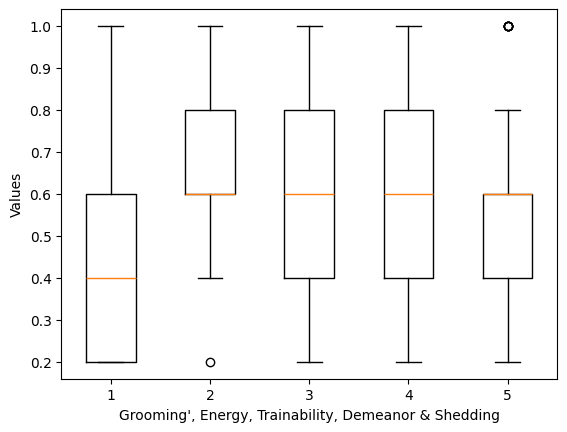

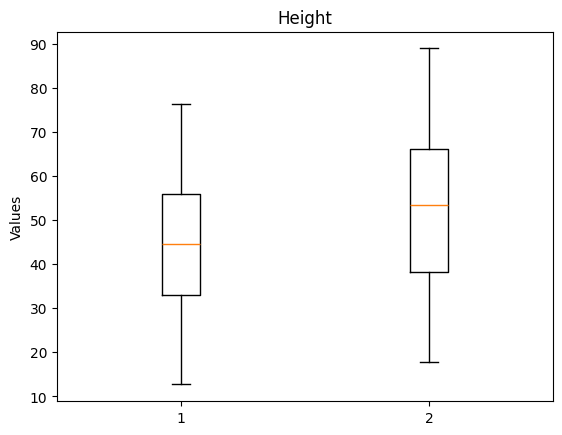

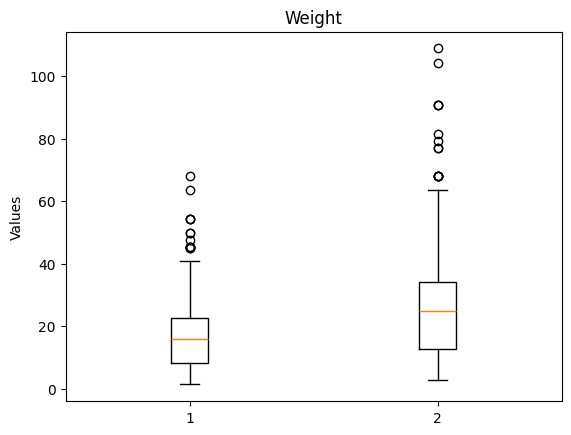

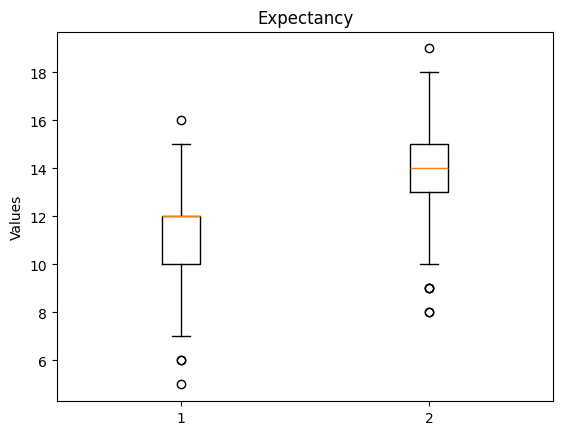

In [110]:
#Boxplot
fig = plt.figure()
plt.ylabel("Values")
plt.xlabel("Grooming', Energy, Trainability, Demeanor & Shedding")
plt.boxplot([data['grooming_frequency_value'].values, data['energy_level_value'].values, data['trainability_value'].values, data['demeanor_value'].values, data['shedding_value'].values])
plt.show()

fig = plt.figure()
plt.ylabel("Values")
plt.title("Height")
plt.boxplot([data['min_height'].values, data['max_height'].values])
plt.show()

fig = plt.figure()
plt.ylabel("Values")
plt.title("Weight")
plt.boxplot([data['min_weight'].values, data['max_weight'].values])
plt.show()

fig = plt.figure()
plt.ylabel("Values")
plt.title("Expectancy")
plt.boxplot([data['min_expectancy'].values, data['max_expectancy'].values])
plt.show()

### Balanceamento

Para lidar com um desequilíbrio na distribuição das classes no conjunto de dados, será feito um oversample aleatório do dataframe, aumentando artificialmente a quantidade de objetos nas classes minoritárias.

In [111]:
ros = RandomOverSampler()
X = data.drop(['group'], axis=1)
y = data.group
X_resampled, y_resampled = ros.fit_resample(X, y)

<Axes: xlabel='group', ylabel='count'>

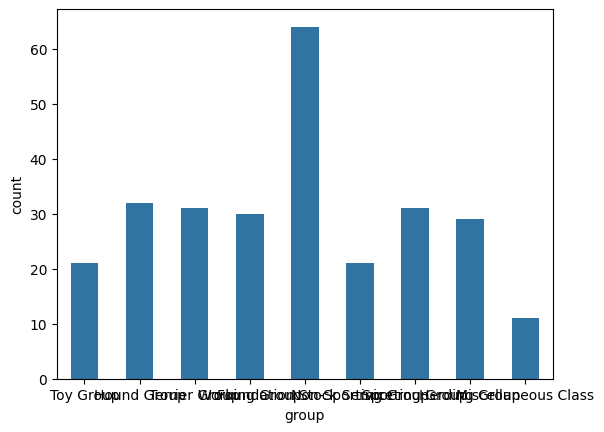

In [112]:
# Objetos de cada classe antes do balanceamento
sns.countplot(x=y, width=0.5)

<Axes: xlabel='group', ylabel='count'>

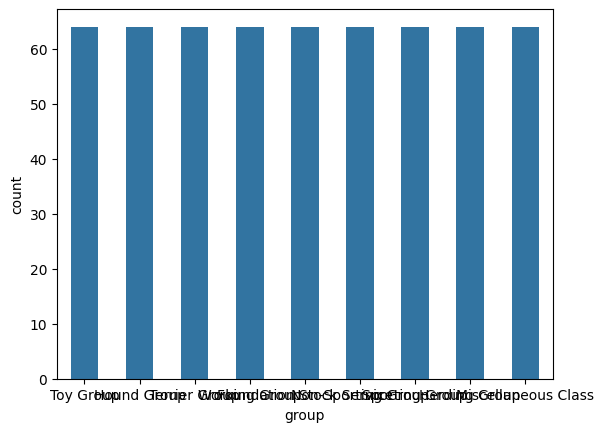

In [113]:
#Após balanceamento
sns.countplot(x=y_resampled, width=0.5)

### Redimensionamento de atributos

Foi escolhido o uso da normalização de dados, a fim de colocar todas as variáveis ou características em uma escala comum, geralmente entre 0 e 1, para que possam ser comparadas ou combinadas de forma adequada. É um procedimento importante para algoritmos sensíveis à escala (Exemplo: K-means) ou quando a distância Euclidiana é usada como: medida de similaridade entre amostras ou aplicação de algoritmos de agrupamento.

In [114]:
# Selecionar as colunas numéricas para normalização
numColumns = data.select_dtypes(include='number').columns

# Criar uma instância do StandardScaler
scaler = StandardScaler()

# Aplicar a escala mínima-máxima nas colunas selecionadas
data[numColumns] = scaler.fit_transform(data[numColumns])

### Atributos entrada e saída

O atributo escolhido como saída foi 'group', que indica **[o que significa]**, por meio de **[string-categoria]**.

Escolheu-se 'group' como saída pois quando observado no DataFrame esse era o único atributo com todas as linhas preenchidas. Além disso, essa seria uma escolha popular para se classificar e a anterior possui a mesma estratégia de implementação que as suas semelhantes (trainability, energy, grooming, demeanor).
Os atributos de entrada estão sendo representados por 'X', enquanto o atributo alvo por 'y'.

In [115]:
#Evitar que o atributo alvo não entre com os atribuos de entrada
data_v2 = data.copy()
X = data_v2.drop('group', axis=1)

#Definir 'group' como target (saída)
y = data_v2["group"]

### Amostragem

Na divisão em conjuntos de teste e treino, foi decidida a seguinte proporção:

- 80% para o conjunto de treino
- 20% para o conjunto de teste

Essa divisão é realizada baseada na estratificação. Nisso, sem ela pode haver uma distribuição desigual das classes nos conjuntos de treinamento e teste, o que pode levar a um modelo tendencioso ou com desempenho insatisfatório.

In [116]:
seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, stratify = y_resampled, random_state = seed)

### Redução da dimensionalidade dos dados

Como a quantidade de atributos é relativamente pequena, foi decidido plotar e analisar a correlação entre atributos de entrada, por meio de um heatmap.

Após a análise da correlação entre atributos de entrada, é preciso decidir entre dropar ou fundir atributos redundantes, ou seja, com correlação forte entre si.

Dessa formam, é possível reduzir o número de atributos utilizados pelo modelo, aumentando sua eficiência ao diminuir o custo computacional para aplicá-lo e, possivelmente, melhorar os resultados das aplicações dos modelos, uma vez que os dados irrelevantes e/ou redundantes não serão mais considerados.

In [117]:
X

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
Affenpinscher,-1.484169,-1.461415,-1.205533,-1.198295,0.376330,0.599077,0.869521,0.387830,-0.670719,0.722143,1.960514
Afghan Hound,1.360631,1.005767,0.388118,-0.008461,0.376330,0.599077,1.887267,-1.780069,0.527176,-1.787430,-2.155702
Airedale Terrier,1.005031,0.369075,0.388118,0.229506,-0.217875,0.054462,0.869521,-0.696120,-0.670719,1.558667,0.931460
Akita,1.182831,1.164940,1.129351,1.657306,-0.812080,-0.490154,1.887267,0.387830,0.527176,1.558667,-0.097594
Alaskan Malamute,1.005031,0.687421,1.314659,0.586456,-0.812080,0.054462,0.869521,0.387830,0.527176,-0.950906,0.931460
...,...,...,...,...,...,...,...,...,...,...,...
Wirehaired Vizsla,0.738331,0.687421,0.202810,0.110522,0.376330,0.054462,-1.165971,0.387830,0.527176,-0.114381,-0.097594
Working Kelpie,0.293831,0.687421,-0.427239,-0.008461,0.376330,0.599077,-1.165971,0.387830,0.527176,-0.950906,-0.097594
Xoloitzcuintli,-1.306369,0.369075,-1.094348,-0.127444,0.970535,2.232922,-1.165971,-1.780069,0.527176,-0.114381,-0.097594
Yakutian Laika,0.649431,0.369075,0.017501,-0.127444,-0.812080,-1.034769,-0.148225,0.387830,0.527176,-1.787430,-1.126648


### Heatmap de correlação inicial

In [118]:
corr = data_v2.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm') 

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
min_height,1.000000,0.935112,0.825014,0.801873,-0.504807,-0.518707,-0.180190,0.301275,0.191791,-0.042950,-0.237682
max_height,0.935112,1.000000,0.804498,0.817340,-0.471856,-0.508941,-0.238197,0.337785,0.209744,-0.046802,-0.294941
min_weight,0.825014,0.804498,1.000000,0.947405,-0.620639,-0.642030,-0.145633,0.293298,-0.049045,-0.124166,-0.263672
max_weight,0.801873,0.817340,0.947405,1.000000,-0.584678,-0.604172,-0.123884,0.289576,-0.056533,-0.072756,-0.260026
min_expectancy,-0.504807,-0.471856,-0.620639,-0.584678,1.000000,0.720219,0.023683,-0.264410,0.015654,0.108391,0.160551
max_expectancy,-0.518707,-0.508941,-0.642030,-0.604172,0.720219,1.000000,0.133469,-0.383911,0.025379,0.096004,0.154839
grooming_frequency_value,-0.180190,-0.238197,-0.145633,-0.123884,0.023683,0.133469,1.000000,-0.071951,-0.153415,0.094884,0.111356
shedding_value,0.301275,0.337785,0.293298,0.289576,-0.264410,-0.383911,-0.071951,1.000000,0.190538,0.041643,-0.174923
energy_level_value,0.191791,0.209744,-0.049045,-0.056533,0.015654,0.025379,-0.153415,0.190538,1.000000,0.102699,-0.000843
trainability_value,-0.042950,-0.046802,-0.124166,-0.072756,0.108391,0.096004,0.094884,0.041643,0.102699,1.000000,0.332027


Com base no heatmap da correlação, percebe-se uma alta correlação entre:

- min_height e max_height
- min_weight e max_weight
- min_expectancy e max_expectancy
- min_height e min_weight
- max_height e max_weight
- min_height e max_weight
- max_height e min_weight

Por isso, realizou-se uma fusão entre os atributos de altura(height), peso(weight) e expectativa de vida (expectancy), utilizando PCA e gerando novos 3 atributos, eliminando os antigos.

In [119]:
# Médias da altura, peso e expectativa
heightMin = np.array(data_v2['min_height'])
heightMax = np.array(data_v2['max_height'])
aux = np.c_[heightMin - heightMin.mean(), heightMax - heightMax.mean()]
pca = PCA(n_components = 1, copy = True) 
heightNew = pca.fit_transform(aux)
data_v2['height'] = heightNew

weightMin = np.array(data_v2['min_weight'])
weightMax = np.array(data_v2['max_weight'])
aux = np.c_[weightMin - weightMin.mean(), weightMax - weightMax.mean()]
pca = PCA(n_components = 1, copy = True)
weightNew = pca.fit_transform(aux)
data_v2['weight'] = weightNew

expectancyMin = np.array(data_v2['min_expectancy'])
expectancyMax = np.array(data_v2['max_expectancy'])
aux = np.c_[expectancyMin - expectancyMin.mean(), expectancyMax - expectancyMax.mean()]
pca = PCA(n_components = 1, copy = True) 
expectancyNew = pca.fit_transform(aux)
data_v2['expectancy'] = expectancyNew

#Médias da altura e peso
meanHeight = (data_v2['min_height'] + data_v2['max_height'])/2
meanWeight = (data_v2['min_weight'] + data_v2['max_weight'])/2

#Excluiu as colunas relacionadas a peso, altura e expectativa e adiciona suas respectivas médias
data_v2 = data_v2.drop(columns=["min_height", "max_height", "min_weight", "max_weight", "min_expectancy", "max_expectancy"])

corr = data_v2.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,height,weight,expectancy
grooming_frequency_value,1.000000,-0.071951,-0.153415,0.094884,0.111356,0.212672,-0.136566,-0.084725
shedding_value,-0.071951,1.000000,0.190538,0.041643,-0.174923,-0.324843,0.295347,0.349529
energy_level_value,-0.153415,0.190538,1.000000,0.102699,-0.000843,-0.204106,-0.053497,-0.022122
trainability_value,0.094884,0.041643,0.102699,1.000000,0.332027,0.045622,-0.099782,-0.110195
demeanor_value,0.111356,-0.174923,-0.000843,0.332027,1.000000,0.270740,-0.265362,-0.170036
height,0.212672,-0.324843,-0.204106,0.045622,0.270740,1.000000,-0.836761,-0.549275
weight,-0.136566,0.295347,-0.053497,-0.099782,-0.265362,-0.836761,1.000000,0.669708
expectancy,-0.084725,0.349529,-0.022122,-0.110195,-0.170036,-0.549275,0.669708,1.000000


Tendo em vista a correlação alta entre peso e altura, faz-se necessária a unificação em um atributo, que será o IMC, sendo seu conteúdo equivalente ao peso/altura de cada linha

Após isso, os atributos são normalizados.

In [120]:
meanImc = (meanHeight * meanHeight) / (meanWeight * 100)

#height e weight estão correlacionadas
data_v2['imc_metric'] = meanImc
data_v2 = data_v2.drop(columns=['height', 'weight'])

#Novos atibutos
scaler = MinMaxScaler()
data_v2['expectancy'] = scaler.fit_transform(data_v2['expectancy'].to_numpy().reshape(-1,1))
data_v2['imc_metric'] = scaler.fit_transform(data_v2['imc_metric'].to_numpy().reshape(-1,1))

corr = data_v2.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,expectancy,imc_metric
grooming_frequency_value,1.000000,-0.071951,-0.153415,0.094884,0.111356,-0.084725,-0.091111
shedding_value,-0.071951,1.000000,0.190538,0.041643,-0.174923,0.349529,0.074543
energy_level_value,-0.153415,0.190538,1.000000,0.102699,-0.000843,-0.022122,0.091830
trainability_value,0.094884,0.041643,0.102699,1.000000,0.332027,-0.110195,-0.005798
demeanor_value,0.111356,-0.174923,-0.000843,0.332027,1.000000,-0.170036,-0.046660
expectancy,-0.084725,0.349529,-0.022122,-0.110195,-0.170036,1.000000,0.048948
imc_metric,-0.091111,0.074543,0.091830,-0.005798,-0.046660,0.048948,1.000000


## Aprendizagem Supervisionada

Métodos utilizados:

    - Decision Tree
    - Naive-Bayes
    - MLP

### Decision Tree

A árvore de decisão tornou-se a primeira escolha devido a ser um algoritmo de aprendizado de máquina amplamente utilizado em tarefas de classificação e regressão. Baseia suas decisões em um conjunto de regras e atributos de entrada. Este modelo é extremamente popular devido a vantagens como: capacidade de lidar com dados mistos, rapidez no treinamento e previsão, e robustez a outliers.

Nesse procedimento, o hiperparâmetro alterado para teste foi o '**Splitter**', sendo a estratégia usada para escolher a divisão em cada nó. As estratégias suportadas são “**best**” para escolher a melhor divisão e “**random**” para escolher a melhor divisão aleatória. Para testes, inclui-se a modificação do hiperparâmetro '**Max_depth**' (A profundidade máxima da árvore), com intuito de mostrar se há uma maior variedade de resultados.

In [121]:
depth = [10, 100, 1000, 10000, 100000]
sptr = ['best', 'random']

hyperparameters = list(itertools.product(sptr, depth))

for x, y in hyperparameters:

  decision_tree_classifier = DecisionTreeClassifier(random_state=50, splitter=x, max_depth=y)

  decision_tree_classifier.fit(X_train, y_train)

  y_pred = decision_tree_classifier.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Splitter: {x}, Max_depth: {y}")
  print('Precisão do modelo: {:.2f}%'.format(accuracy * 100))

Splitter: best, Max_depth: 10
Precisão do modelo: 72.41%
Splitter: best, Max_depth: 100
Precisão do modelo: 78.45%
Splitter: best, Max_depth: 1000
Precisão do modelo: 78.45%
Splitter: best, Max_depth: 10000
Precisão do modelo: 78.45%
Splitter: best, Max_depth: 100000
Precisão do modelo: 78.45%
Splitter: random, Max_depth: 10
Precisão do modelo: 76.72%
Splitter: random, Max_depth: 100
Precisão do modelo: 82.76%
Splitter: random, Max_depth: 1000
Precisão do modelo: 82.76%
Splitter: random, Max_depth: 10000
Precisão do modelo: 82.76%
Splitter: random, Max_depth: 100000
Precisão do modelo: 82.76%


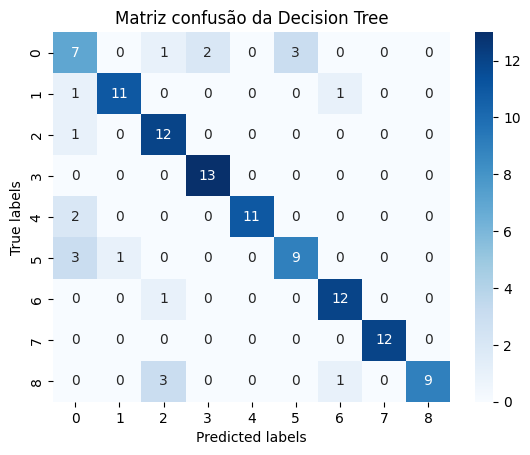

In [122]:
cm_dt = confusion_matrix(y_test, y_pred)

xlabel = np.unique(list(y_test))
sns.heatmap(cm_dt, annot=True, cmap="Blues", label=xlabel)
plt.title('Matriz confusão da Decision Tree')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [123]:
print('Métricas da Decision Tree')
print(classification_report(y_test, y_pred))

Métricas da Decision Tree
                          precision    recall  f1-score   support

Foundation Stock Service       0.50      0.54      0.52        13
           Herding Group       0.92      0.85      0.88        13
             Hound Group       0.71      0.92      0.80        13
     Miscellaneous Class       0.87      1.00      0.93        13
      Non-Sporting Group       1.00      0.85      0.92        13
          Sporting Group       0.75      0.69      0.72        13
           Terrier Group       0.86      0.92      0.89        13
               Toy Group       1.00      1.00      1.00        12
           Working Group       1.00      0.69      0.82        13

                accuracy                           0.83       116
               macro avg       0.84      0.83      0.83       116
            weighted avg       0.84      0.83      0.83       116



### Naive-Bayes

In [128]:
# Inicializar o classificador Naive Bayes Gaussiano
classifier = GaussianNB()

# Treinar o modelo com os dados de treinamento
classifier.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred_nb = classifier.predict(X_test)

# Calcular a precisão do modelo
accuracy = accuracy_score(y_test, y_pred_nb)
print("Acurácia do modelo Naive Bayes:", accuracy)

Acurácia do modelo Naive Bayes: 0.47413793103448276


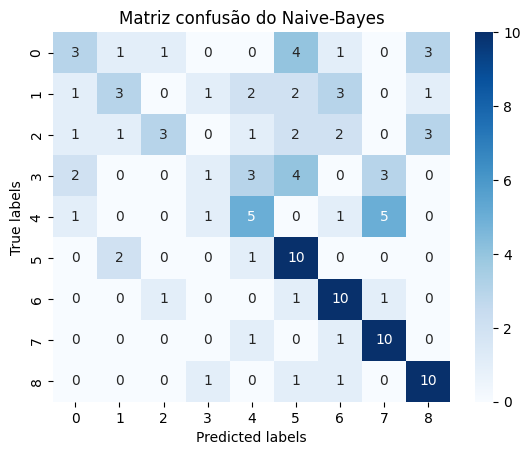

In [130]:
cm_rf = confusion_matrix(y_test, y_pred_nb)

xlabel = np.unique(list(y_test))
sns.heatmap(cm_rf, annot=True, cmap="Blues", label=xlabel)
plt.title('Matriz confusão do Naive-Bayes')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [131]:
print('Métricas do Naive-Bayes')
print(classification_report(y_test, y_pred_nb))

Métricas do Naive-Bayes
                          precision    recall  f1-score   support

Foundation Stock Service       0.38      0.23      0.29        13
           Herding Group       0.43      0.23      0.30        13
             Hound Group       0.60      0.23      0.33        13
     Miscellaneous Class       0.25      0.08      0.12        13
      Non-Sporting Group       0.38      0.38      0.38        13
          Sporting Group       0.42      0.77      0.54        13
           Terrier Group       0.53      0.77      0.62        13
               Toy Group       0.53      0.83      0.65        12
           Working Group       0.59      0.77      0.67        13

                accuracy                           0.47       116
               macro avg       0.46      0.48      0.43       116
            weighted avg       0.45      0.47      0.43       116

